In [65]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Concatenate, Dropout, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK data files
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Step 1: Load Historical Stock Data for Microsoft (MSFT)

In [66]:
msft = yf.download('MSFT', start='2010-01-01', end=datetime.today())
msft.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [67]:
#Checking for the column names
msft.columns

MultiIndex([(     'Date',     ''),
            ('Adj Close', 'MSFT'),
            (    'Close', 'MSFT'),
            (     'High', 'MSFT'),
            (      'Low', 'MSFT'),
            (     'Open', 'MSFT'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])

In [68]:
# Features from historical data
msft['Day'] = msft['Date'].dt.day
msft['Month'] = msft['Date'].dt.month
msft['Year'] = msft['Date'].dt.year
msft['DayOfWeek'] = msft['Date'].dt.dayofweek

In [69]:
#Data Check
msft.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,Day,Month,Year,DayOfWeek
Ticker,,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,,,,
0,2010-01-04 00:00:00+00:00,23.300686,30.950001,31.100000,30.590000,30.620001,38409100,4,1,2010,0
1,2010-01-05 00:00:00+00:00,23.308205,30.959999,31.100000,30.639999,30.850000,49749600,5,1,2010,1
2,2010-01-06 00:00:00+00:00,23.165161,30.770000,31.080000,30.520000,30.879999,58182400,6,1,2010,2
3,2010-01-07 00:00:00+00:00,22.924248,30.450001,30.700001,30.190001,30.629999,50559700,7,1,2010,3
4,2010-01-08 00:00:00+00:00,23.082352,30.660000,30.879999,30.240000,30.280001,51197400,8,1,2010,4


In [70]:
# Simulated news headlines
# News are created by us - it is not auto generated
news_data = pd.DataFrame({
    'Date': pd.date_range(start='2010-01-01', periods=len(msft), freq='D'),
    'Headline': np.random.choice([
        'Microsoft launches new product today',
        'Stock market falls due to economic concerns',
        'Tech stocks soar amidst new advancements',
        'Global markets unstable amid political tensions',
        'Positive earnings report boosts investor confidence'
    ], size=len(msft))
})

In [71]:
#Check for News data frame
news_data.head()

,Date,Headline
0,2010-01-01,Global markets unstable amid political tensions
1,2010-01-02,Stock market falls due to economic concerns
2,2010-01-03,Stock market falls due to economic concerns
3,2010-01-04,Tech stocks soar amidst new advancements
4,2010-01-05,Stock market falls due to economic concerns


In [72]:
#Convert news data date column to datetime
news_data['Date'] = pd.to_datetime(news_data['Date'])

In [73]:
# Merge stock data with news headlines
# reset the index to make 'Date' a regular column
msft = msft.reset_index()
news_data = news_data.reset_index()

# Drop the extra index level in msft if it exists
if isinstance(msft.columns, pd.MultiIndex):
    msft.columns = msft.columns.droplevel(level=1) # Dropping level 1 if there are 2 levels

# Ensure both 'Date' columns have the same dtype - datetime64[ns]
msft['Date'] = pd.to_datetime(msft['Date']).dt.tz_localize(None)
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Now we can merge
data = pd.merge(msft, news_data, on='Date', how='left')

In [74]:
data.head()

,index_x,Date,Adj Close,Close,High,Low,Open,Volume,Day,Month,Year,DayOfWeek,index_y,Headline
0,0,2010-01-04,23.300686,30.950001,31.100000,30.590000,30.620001,38409100,4,1,2010,0,3.0,Tech stocks soar amidst new advancements
1,1,2010-01-05,23.308205,30.959999,31.100000,30.639999,30.850000,49749600,5,1,2010,1,4.0,Stock market falls due to economic concerns
2,2,2010-01-06,23.165161,30.770000,31.080000,30.520000,30.879999,58182400,6,1,2010,2,5.0,Microsoft launches new product today
3,3,2010-01-07,22.924248,30.450001,30.700001,30.190001,30.629999,50559700,7,1,2010,3,6.0,Global markets unstable amid political tensions
4,4,2010-01-08,23.082352,30.660000,30.879999,30.240000,30.280001,51197400,8,1,2010,4,7.0,Stock market falls due to economic concerns


In [75]:
# Step 3: Sentiment Analysis on News Headlines
sid = SentimentIntensityAnalyzer()
# Convert 'Headline' column to string and handle NaN values
data['Headline'] = data['Headline'].astype(str).fillna('')
data['Sentiment'] = data['Headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [76]:
# Fill missing sentiment values with zero if no headline is available
data['Sentiment'].fillna(0, inplace=True)

<ipython-input-76-50624c2f9ce5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Sentiment'].fillna(0, inplace=True)


In [77]:
# Step 4: Prepare Data for the Model
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Day', 'Month', 'Year', 'DayOfWeek']
target = 'Adj Close'

In [78]:
# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[[target]])

In [79]:
# Define input and output sequences
sequence_length = 60  # Use the past 60 days to predict the next day's price

In [80]:
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(target[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [81]:
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

In [82]:
# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [83]:
# Step 5: Build Multiple Models

models = {}
histories = {}
predictions = {}

In [84]:
# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])

In [85]:
# Model 1: Transformer Model (from Phase 1)
def build_transformer_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=input_shape[1], dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [86]:
# Model 2: LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [87]:
# Model 3: GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [88]:
# Model 4: CNN-LSTM Hybrid Model
def build_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [89]:
# Build and compile models
models['Transformer'] = build_transformer_model()
models['LSTM'] = build_lstm_model()
models['GRU'] = build_gru_model()
models['CNN-LSTM'] = build_cnn_lstm_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
# Model Summaries
print("\nModel Summaries:")
for name, model in models.items():
    print(f"\n{name} Model Summary:")
    model.summary()


Model Summaries:

Transformer Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 10)         │             20 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 10)         │          1,730 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 10)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 10)         │             20 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 60, 128)        │          1,408 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 60, 128)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ dropout_2[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            129 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,307 (12.92 KB)

 Trainable params: 3,307 (12.92 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)


GRU Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 128)             │          53,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,073 (355.75 KB)

 Trainable params: 91,073 (355.75 KB)

 Non-trainable params: 0 (0.00 B)


CNN-LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 58, 64)              │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 56, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,387 (146.04 KB)

 Trainable params: 37,387 (146.04 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Step 6: Train the Models
epochs = 20
batch_size = 32

for name, model in models.items():
    print(f"\nTraining {name} model...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )
    histories[name] = history


Training Transformer model...
Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0239 - val_loss: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.8917e-04 - val_loss: 0.0016
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.8603e-04 - val_loss: 0.0013
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.9791e-04 - val_loss: 0.0015
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.6604e-04 - val_loss: 0.0016
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.5085e-04 - val_loss: 0.0024
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.2140e-04 - val_loss: 0.0021
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.6984e-04 - val_loss: 0.0026
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7998e-04 - val_loss: 0.0026
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2.8139e-04 - val_loss: 0.0025
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.5815e-04 - val_loss:

In [92]:
# Step 7: Evaluate the Models
from sklearn.metrics import mean_squared_error

for name, model in models.items():
    print(f"\nEvaluating {name} model...")
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    # Inverse transform the predictions and actual values
    y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(features)-1)), y_pred), axis=1))[:, -1]
    y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(features)-1)), y_test), axis=1))[:, -1]
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"{name} Model RMSE: {rmse:.2f}")


Evaluating Transformer model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Transformer Model RMSE: 148.99

Evaluating LSTM model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
LSTM Model RMSE: 21.80

Evaluating GRU model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
GRU Model RMSE: 17.73

Evaluating CNN-LSTM model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
CNN-LSTM Model RMSE: 40.83


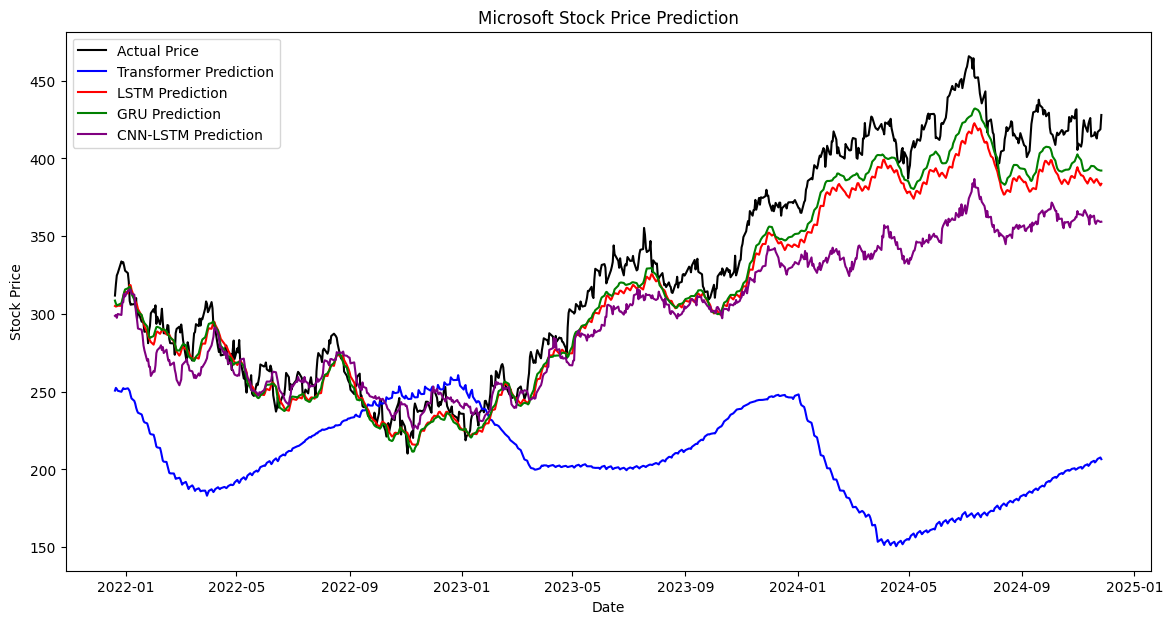

In [93]:
# Step 8: Visualize the Results
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test):], y_test_inv, label='Actual Price', color='black')

colors = ['blue', 'red', 'green', 'purple']
for idx, (name, y_pred) in enumerate(predictions.items()):
    y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(features)-1)), y_pred), axis=1))[:, -1]
    plt.plot(data['Date'][-len(y_test):], y_pred_inv, label=f'{name} Prediction', color=colors[idx])

plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [94]:
# Step 9: Choose the Best Model and Generate Trading Signals
# Choose the model with the lowest RMSE
best_model_name = min(models.keys(), key=lambda name: np.sqrt(mean_squared_error(
    scaler.inverse_transform(np.concatenate((np.zeros((predictions[name].shape[0], len(features)-1)), predictions[name]), axis=1))[:, -1],
    scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(features)-1)), y_test), axis=1))[:, -1]
)))
print(f"\nBest Model: {best_model_name}")

best_pred = predictions[best_model_name]
best_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((best_pred.shape[0], len(features)-1)), best_pred), axis=1))[:, -1]



Best Model: GRU


In [95]:
# Generate trading signals based on the best model
trading_signals = ['Hold']  # First day, we don't have a previous price to compare
for i in range(1, len(best_pred_inv)):
    if best_pred_inv[i] > y_test_inv[i-1]:
        trading_signals.append('Buy')
    elif best_pred_inv[i] < y_test_inv[i-1]:
        trading_signals.append('Sell')
    else:
        trading_signals.append('Hold')

trading_dates = data['Date'][-len(y_test):].reset_index(drop=True)

trading_strategy = pd.DataFrame({
    'Date': trading_dates,
    'Actual Price': y_test_inv,
    'Predicted Price': best_pred_inv,
    'Signal': trading_signals
})

print(trading_strategy.head())

        Date  Actual Price  Predicted Price Signal
0 2021-12-20    311.822906       308.606621   Hold
1 2021-12-21    319.016357       306.685435   Sell
2 2021-12-22    324.776917       305.556794   Sell
3 2021-12-23    326.229279       305.726259   Sell
4 2021-12-27    333.793060       306.870024   Sell


In [96]:
# Step 10: Backtesting the Strategy
initial_money = 10000
shares = 5
money = initial_money

for i in range(1, len(trading_signals)):
    price = y_test_inv[i]
    signal = trading_signals[i]
    if signal == 'Buy' and money >= price:
        shares_to_buy = money // price
        shares += shares_to_buy
        money -= shares_to_buy * price
    elif signal == 'Sell' and shares > 0:
        money += shares * price
        shares = 0

In [97]:
# Final portfolio value
final_value = money + shares * y_test_inv[-1]
print(f'\nInitial Money: ${initial_money}')
print(f'Final Portfolio Value: ${final_value:.2f}')
print(f'Net Profit: ${final_value - initial_money:.2f}')


Initial Money: $10000
Final Portfolio Value: $13214.80
Net Profit: $3214.80
